In [2]:
import numpy as np
import open3d as o3d
import os

def compute_plane_parameters(points,mean):
    u, s, vh = np.linalg.svd(points)

    normal = vh[-1]
    offset = np.dot(normal, mean)
    if offset <= 0:
        offset *= -1
        normal *= -1
    
    return normal, offset

def compute_all_plane_parameters(pcd_dir):
    lidar_plane_normals = []
    lidar_offsets = []
    for file in os.listdir(pcd_dir):
        if file.endswith(".pcd"):
            pcd_file = os.path.join(pcd_dir, file)
            pcd = o3d.io.read_point_cloud(pcd_file)
            points = np.asarray(pcd.points)
            mean = np.mean(points, axis = 0)
            points -=  mean
            normal, offset = compute_plane_parameters(points,mean)
            lidar_plane_normals.append(normal)
            lidar_offsets.append(offset)
    lidar_plane_normals = np.array(lidar_plane_normals)
    lidar_offsets = np.array(lidar_offsets)

    return lidar_plane_normals, lidar_offsets

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
pcd_dir = 'CV-A2-Q5\lidar_scans'

lidar_plane_normals, lidar_offsets = compute_all_plane_parameters(pcd_dir)


print(lidar_plane_normals.shape)
print(lidar_offsets.shape)
print(lidar_offsets)
print(max(lidar_offsets))

(38, 3)
(38,)
[ 4.9938113   4.72077966  5.20430555  4.79350163  5.22080334  5.70252458
  6.32357222  6.44543972  5.67425846  5.74369429  5.06235221  4.95401545
  5.25498423  6.10364557  5.43672051  8.2131326   7.43554678  8.0209935
  9.49902545 10.30997961  8.14058237  8.72427267  7.27175232  6.59505822
  6.98783595  6.58956459  4.772067    3.70387562  3.97154215  7.61870018
  6.09367868  5.97813104  6.26535812  7.32519714  8.49322105  8.84616892
  7.74946415  6.96918888]
10.309979614425066


In [4]:
def read_camera_normals(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        normal = np.array([float(line.strip()) for line in lines])
    return normal

def read_rotation_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        rotation_matrix = np.array([[float(value) for value in line.strip().split()] for line in lines])
    return rotation_matrix

def read_translation_vector(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        translation_vector = np.array([float(line.strip()) for line in lines])
    return translation_vector

camera_dir = 'CV-A2-Q5\camera_parameters'

camera_normals = []
rotation_matrices = []
translation_vectors = []

for frame_folder in os.listdir(camera_dir):
    # print(frame_folder)
    frame_folder_path = os.path.join(camera_dir, frame_folder)
    if os.path.isdir(frame_folder_path):
        # print(frame_folder_path)
        normals_file_path = os.path.join(frame_folder_path, 'camera_normals.txt')
        rotation_matrix_file_path = os.path.join(frame_folder_path, 'rotation_matrix.txt')
        translation_vector_file_path = os.path.join(frame_folder_path, 'translation_vectors.txt')
 
        normal = read_camera_normals(normals_file_path)
        rotation_matrix = read_rotation_matrix(rotation_matrix_file_path)
        translation_vector = read_translation_vector(translation_vector_file_path)

        camera_normals.append(normal)
        rotation_matrices.append(rotation_matrix)
        translation_vectors.append(translation_vector)

camera_normals = np.array(camera_normals)
rotation_matrices = np.array(rotation_matrices)
translation_vectors = np.array(translation_vectors)

print(camera_normals.shape)
print(rotation_matrices.shape)
print(translation_vectors.shape)

(38, 3)
(38, 3, 3)
(38, 3)


Find the shifted origin in world 

In [5]:
new_origins = []

for i in range(len(rotation_matrices)):
    translated_origin = np.array([0, 0, 0]) - translation_vectors[i]

    rotated_origin = np.dot(rotation_matrices[i], translated_origin)

    new_origins.append(rotated_origin)

new_origins = np.array(new_origins)

print(new_origins.shape)

(38, 3)


Find the offset for each image and store it

In [6]:
import copy
camera_offsets = []
new_camera_normals = []

for i in range(len(new_origins)):
    camera_normal = camera_normals[i]

    new_origin = new_origins[i]

    offset = -np.dot(camera_normal, new_origin)
    if offset <= 0 :
        offset *= -1
        camera_normal *= -1
        new_camera_normals.append(camera_normal)
    else:
        new_camera_normals.append(camera_normal)
    
    camera_offsets.append(offset)

camera_offsets = np.array(camera_offsets)

camera_normals = np.array(copy.deepcopy(new_camera_normals))
print(camera_normals.shape)
print(camera_offsets.shape)

(38, 3)
(38,)


In [35]:
print(lidar_offsets)

[ 4.9938113   4.72077966  5.20430555  4.79350163  5.22080334  5.70252458
  6.32357222  6.44543972  5.67425846  5.74369429  5.06235221  4.95401545
  5.25498423  6.10364557  5.43672051  8.2131326   7.43554678  8.0209935
  9.49902545 10.30997961  8.14058237  8.72427267  7.27175232  6.59505822
  6.98783595  6.58956459  4.772067    3.70387562  3.97154215  7.61870018
  6.09367868  5.97813104  6.26535812  7.32519714  8.49322105  8.84616892
  7.74946415  6.96918888]


In [36]:
print(camera_offsets)

[4.40727584 4.89556664 4.88480759 4.94436213 5.64515455 5.88719251
 5.48527475 6.20411657 5.44359777 5.39575113 4.08495003 4.47950227
 4.69488219 5.26968172 4.88721444 7.57451409 7.29468237 7.69113637
 9.18673335 9.19848412 7.15808026 8.66354827 8.04161049 7.13507991
 5.75399516 5.47658268 4.24145183 4.35808307 3.16382492 6.80014164
 5.5183504  6.01885964 5.63948866 6.73460311 7.91434177 8.27922574
 7.36643512 5.96640208]


In [37]:
print(camera_offsets-lidar_offsets)

[-0.58653545  0.17478698 -0.31949796  0.1508605   0.42435122  0.18466794
 -0.83829747 -0.24132315 -0.23066069 -0.34794316 -0.97740218 -0.47451318
 -0.56010203 -0.83396385 -0.54950607 -0.63861851 -0.14086441 -0.32985713
 -0.3122921  -1.11149549 -0.98250211 -0.0607244   0.76985817  0.54002169
 -1.23384079 -1.11298191 -0.53061517  0.65420745 -0.80771723 -0.81855854
 -0.57532828  0.04072861 -0.62586946 -0.59059403 -0.57887928 -0.56694318
 -0.38302903 -1.0027868 ]


Estimate Lidar translate vectors

In [ ]:
camera_normals_real = camera_normals.T
print(camera_normals_real.shape)

theta_c_theta_c_transpose = np.matmul(camera_normals_real, camera_normals_real.T)
print(theta_c_theta_c_transpose.shape)

theta_c_theta_c_transpose_inv = np.linalg.inv(theta_c_theta_c_transpose) # -------- (i)
print(theta_c_theta_c_transpose_inv.shape)

offset_difference = camera_offsets - lidar_offsets # ---------- (i)
print(offset_difference.shape)

lidar_translate_vectors = np.matmul(np.matmul(theta_c_theta_c_transpose_inv,camera_normals_real,),offset_difference)

print(lidar_translate_vectors)

Estimate Lidar rotation matrix

In [10]:
lidar_plane_normals_real = lidar_plane_normals.T
u, s, vh = np.linalg.svd(np.matmul(lidar_plane_normals_real,camera_normals)) # ------- (i)
print(np.matmul(lidar_plane_normals_real,camera_normals).shape)
lidar_rotation_matrix = np.matmul(vh.T,u.T)
# lidar_rotation_matrix[-1] *= -1
print(lidar_rotation_matrix.shape)
print(lidar_rotation_matrix)
determinant = np.linalg.det(lidar_rotation_matrix)
print(determinant)

(3, 3)
(3, 3)
[[-1.75158876e-01 -9.84540172e-01  1.36164316e-04]
 [ 1.53559935e-02 -2.87025999e-03 -9.99877970e-01]
 [ 9.84420419e-01 -1.75135410e-01  1.56213440e-02]]
1.0000000000000009


In [ ]:
def transformation_matrix(lidar_point):
    tl = lidar_point + lidar_translate_vectors
    rl = np.matmul(lidar_rotation_matrix,tl)

    return rl

Estimating Camera points using Lidar points

Plotting and Cosine Similarities

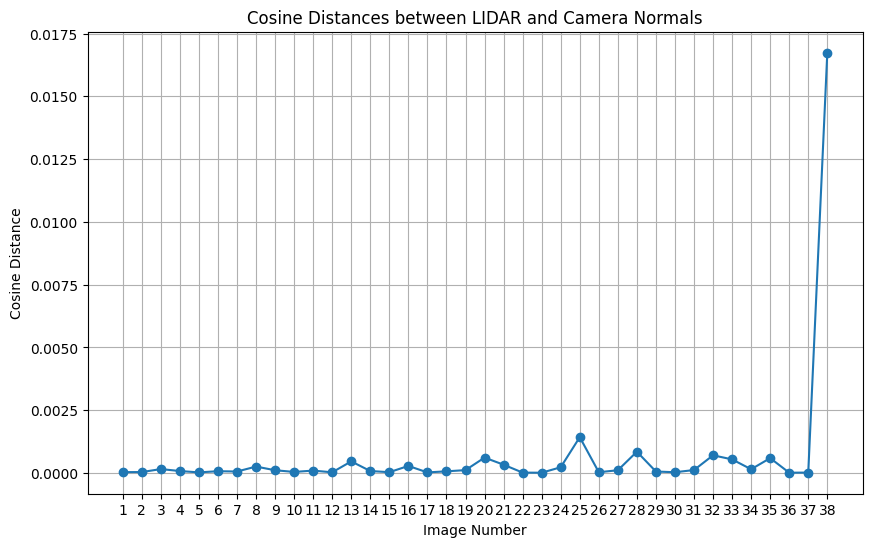

Average Error: 0.0006469021634401726
Standard Deviation: 0.0026610000720887527


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

cosine_distances = []
c_norm_est_list = []

for i in range(38):
    l_norm = lidar_plane_normals[i]
    l_rotmat = lidar_rotation_matrix
    c_norm_est = np.matmul(l_rotmat, l_norm)
    c_norm_est_list.append(c_norm_est)
    v1 = c_norm_est.reshape(1, -1)
    v2 = camera_normals[i].reshape(1, -1)

    cosine_sim = cosine_similarity(v1, v2)
    cosine_dist = 1 - cosine_sim

    cosine_distances.append(cosine_dist[0][0])

plt.figure(figsize=(10, 6))
plt.plot(range(1, 39), cosine_distances, marker='o', linestyle='-')
plt.title('Cosine Distances between LIDAR and Camera Normals')
plt.xlabel('Image Number')
plt.ylabel('Cosine Distance')
plt.grid(True)
plt.xticks(range(1, 39))
plt.show()   

average_error = np.mean(cosine_distances)
std_deviation = np.std(cosine_distances)

print("Average Error:", average_error)
print("Standard Deviation:", std_deviation)

Calculate and stroe the projected points

In [22]:
import cv2

path = "CV-A2-Q5\camera_parameters\camera_intrinsic.txt"
path2 = "CV-A2-Q5\camera_parameters\distortion.txt"
intrinsic_params = np.loadtxt(path)
dist = np.loadtxt(path2)
intrinsic_params = intrinsic_params.reshape(3, 3)
dist = dist.reshape(5,)

def lidar_points_cam(lidar_points, lidar_rotation_matrix, lidar_translate_vectors, intrinsic_params):
    projected_points = cv2.projectPoints(lidar_points, lidar_rotation_matrix, lidar_translate_vectors, intrinsic_params, dist)[0][:, 0, :]
    return projected_points

In [24]:
pcd_dir = 'CV-A2-Q5/lidar_scans'

lidar_points_list = []

for file in os.listdir(pcd_dir):
    if file.endswith(".pcd"):
        pcd_file = os.path.join(pcd_dir, file)
        # Read the .pcd file
        pcd = o3d.io.read_point_cloud(pcd_file)
        # Convert to numpy array
        points = np.asarray(pcd.points)

        projected_points = lidar_points_cam(points, lidar_rotation_matrix, lidar_translate_vectors, intrinsic_params)
        lidar_points_list.append(projected_points)

print(projected_points.shape)

start_x,start_y = np.mean(projected_points,axis = 0)
print(start_x,start_y)

(120, 2)
862.7129490431699 455.95320517183785


In [20]:
print(projected_points)

[[819.98151863 467.71982301]
 [820.01237041 443.27588715]
 [820.12663682 419.02678866]
 [822.32301478 492.46059337]
 [822.52023267 467.75391509]
 [822.52819361 443.31669781]
 [822.64032537 419.04596364]
 [824.83379325 492.561692  ]
 [824.9254023  467.80271   ]
 [825.04190783 443.36825915]
 [825.16059147 419.06174798]
 [827.23757332 492.64277341]
 [827.30188817 467.89584008]
 [827.55932586 419.07653823]
 [829.66130087 492.70825151]
 [829.84166215 467.95024957]
 [830.00082628 443.40405304]
 [829.95780499 419.09932717]
 [832.33440527 492.79425166]
 [832.38891905 468.0028004 ]
 [832.52801492 443.45788015]
 [832.63171544 419.0947225 ]
 [834.88387473 492.87935632]
 [835.07074535 468.05717263]
 [835.19352339 443.50493548]
 [835.18009557 419.09664017]
 [837.56333513 492.97330835]
 [837.84619267 419.12355376]
 [840.04268653 468.1900802 ]
 [840.03870772 443.58075866]
 [840.12599163 419.16191558]
 [842.42075081 493.15290945]
 [842.59077252 468.27035971]
 [842.60210233 443.61385346]
 [842.68431688

Plot all 3 normals on the images

In [31]:
img_list = ["frame_1061.jpeg", "frame_1075.jpeg", "frame_1093.jpeg", "frame_1139.jpeg", "frame_1153.jpeg"]
img_path = "CV-A2-Q5/camera_images/"
for i in range(5):
    image = cv2.imread(os.path.join(img_path, img_list[i]))
    start_x,start_y = np.mean(lidar_points_list[i],axis = 0)

    end_lidar_point_x = start_x - (lidar_plane_normals[i][0]*100)
    end_lidar_point_y = start_y - (lidar_plane_normals[i][1]*100)

    end_camera_point_x = start_x - (camera_normals[i][0]*100)
    end_camera_point_y = start_y - (camera_normals[i][1]*100)

    end_est_point_x = start_x - (c_norm_est_list[i][0]*100)
    end_est_point_y = start_y - (c_norm_est_list[i][1]*100)
    
    #LIDAR
    cv2.arrowedLine(image,(int(start_x), int(start_y)), (int(end_lidar_point_x),int(end_lidar_point_y)), (255,0,0), 3)

    #CAMERA
    cv2.arrowedLine(image,(int(start_x), int(start_y)), (int(end_camera_point_x),int(end_camera_point_y)), (0,255,0), 3)

    #CAM_ESTIMATE
    cv2.arrowedLine(image,(int(start_x), int(start_y)), (int(end_est_point_x),int(end_est_point_y)), (0,0,255), 3)

    cv2.imwrite(f"Normals{i}.jpeg",image)

Plot the reprojected points onto the images

In [34]:
img_path = "CV-A2-Q5/camera_images/"

for i in range(5):
    image = cv2.imread(os.path.join(img_path, img_list[i]))
    for j in range(len(lidar_points_list[i])):
        cv2.circle(image, (int(lidar_points_list[i][j][0]), int(lidar_points_list[i][j][1])), 2, (0, 0, 255), -1)
    
    cv2.imwrite(f"Points{i}.jpeg",image)
    